<a href="https://colab.research.google.com/github/Viny2030/HUMAI/blob/main/ejercicios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/institutohumai/machine_learning/blob/main/6_Ensamble/ejercicios/ejercicios.ipynb"> <img src='https://colab.research.google.com/assets/colab-badge.svg' /> </a>

# Práctica Ensambles I

## Consignas
El objetivo de esta práctica es comparar la performance de diferentes clasificadores basados en ensamble learning y un clasificador simple (árbol de decisión, regresión logística u otros).

**1. Cargamos los paquetes a utilizar**


In [ ]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import fetch_openml
import numpy as np
from matplotlib import pyplot as plt

**2. Importamos el dataset mnist**

In [ ]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

c:\Users\gere-\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Se trata de un dataset de digitos escritos a mano.

Los dígitos se normalizaron en tamaño y se centraron en una imagen de tamaño fijo. Es una buena base de datos para las personas que desean probar técnicas de aprendizaje y métodos de reconocimiento de patrones en datos del mundo real mientras dedican un esfuerzo mínimo al preprocesamiento y formateo.

Las imágenes originales en blanco y negro (dos niveles) del NIST se normalizaron en tamaño para que cupieran en un cuadro de 20 x 20 píxeles conservando su relación de aspecto.

Las imágenes resultantes contienen niveles de gris como resultado de la técnica de suavizado utilizada por el algoritmo de normalización. las imágenes se centraron en una imagen de 28x28 calculando el centro de masa de los píxeles y traduciendo la imagen para posicionar este punto en el centro del campo de 28x28.

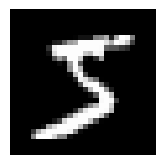

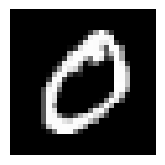

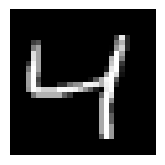

In [ ]:
for i in range(0,3):
  plt.subplot(130 + 1 + i)
  d = np.array(mnist.data[i,:]).reshape(28, 28)
  plt.imshow(d, cmap=plt.get_cmap('gray'))
  plt.axis('off')
  plt.show()

**3. Dividimos en train y test**

>> ¿Qué forma/dimensión tienen los datos?

**4. Instanciamos los clasificadores**

**5. Hacemos el entrenamiento de cada uno de los modelos elegidos**

**6. Evaluamos los resultados**

> ¿Cuál sería la métrica más adecuada para evaluar estos modelos?

> ¿Cuál es el mejor modelo?

> ¿Qué diferencias ven entre los clasificadores?


Ahora intenten graficar. Recuerden que hay metodos para graficar que pueden hacer que el grafico quede mas limpio, y con ello, mas analizable.

**7. Mejorando los resultados?**

> ¿Qué podría hacerse para mejorar la performance de los diferentes modelos?

> ¿Cuál es el modelo que podría tunearse de forma mpas efectiva?  Avanzar en el tuneo de los hiperparámetros del mismo

In [ ]:
#Pueden utilizar las siguientes librerias
#from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV

# Definimos la grilla de valores sobre los que vamos a buscar

# Seteamos el modo de evaluación

# Definimos el proceso de búsqueda (en este caso, exhaustivo)

# Ejecutamos la búsqueda
